In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 이걸루 성공1
import os
from getpass import getpass

os.environ['KAGGLE_USERNAME'] = input("Enter your Kaggle username: ")
os.environ['KAGGLE_KEY'] = getpass("Enter your Kaggle API key: ")


Enter your Kaggle username: moominj
Enter your Kaggle API key: ··········


In [3]:
# 이걸루 성공2
import os
import zipfile
import shutil

# Download the dataset directly to the /content directory in Colab
os.system('kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content')

# Extract the dataset to /content
zip_file = '/content/chest-xray-pneumonia.zip'
output_dir = '/content/chest_xray'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Dataset extracted to {output_dir}")

# Clean up the zip file
os.remove(zip_file)

# Confirm paths for train, validation, and test sets
train_path = os.path.join(output_dir, 'chest_xray', 'train')
val_path = os.path.join(output_dir, 'chest_xray', 'val')
test_path = os.path.join(output_dir, 'chest_xray', 'test')

print("Train Path:", train_path)
print("Validation Path:", val_path)
print("Test Path:", test_path)


Dataset extracted to /content/chest_xray
Train Path: /content/chest_xray/chest_xray/train
Validation Path: /content/chest_xray/chest_xray/val
Test Path: /content/chest_xray/chest_xray/test


In [4]:
import os

# Specify the base path for your dataset
base_path = '/content'  # Replace with your actual base path
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Define the class folders you want to create (e.g., 'NORMAL' and 'PNEUMONIA')
classes = ['NORMAL', 'PNEUMONIA']

# Create directories if they do not exist
for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        os.makedirs(path)
    for cls in classes:
        class_path = os.path.join(path, cls)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

print("Directories created successfully!")


Directories created successfully!


In [5]:
import shutil

import kagglehub

# Download latest version
source_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
train_path = '/content/chest_xray/train/'
val_path = '/content/chest_xray/val'
test_path = '/content/chest_xray/test'
destination_path = '/content'

# Example of moving files to their respective directories
# source_path = 'path_to_source_images'  # Replace with the path where your images currently are
destination_path = train_path  # Replace with the desired destination (e.g., train_path, val_path, or test_path)

for cls in classes:
    cls_source_path = os.path.join(source_path, cls)
    cls_destination_path = os.path.join(destination_path, cls)

    if os.path.exists(cls_source_path):
        for img_file in os.listdir(cls_source_path):
            shutil.move(os.path.join(cls_source_path, img_file), cls_destination_path)

print("Files moved successfully!")


100%|██████████| 2.29G/2.29G [00:16<00:00, 146MB/s]

Extracting files...


Files moved successfully!


In [6]:
!rm -r /content/chest_xray/chest_xray/chest_xray

Class 'NORMAL' has 1341 images.
Class 'PNEUMONIA' has 3875 images.


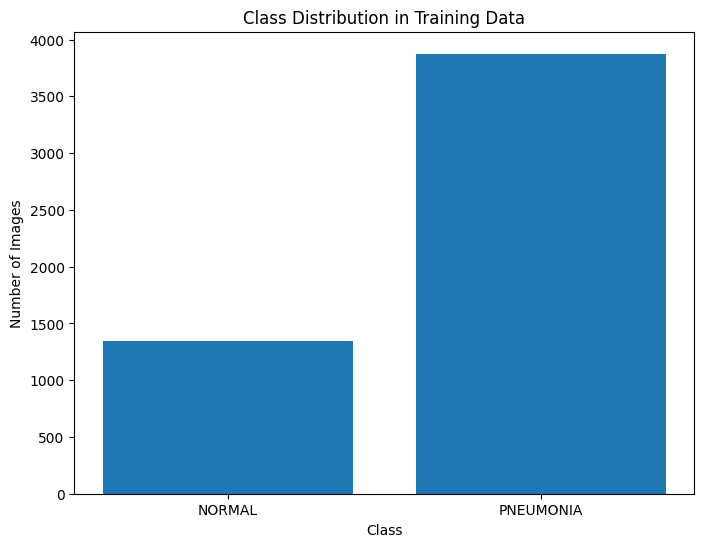

In [7]:
# 필수 라이브러리 임포트
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 데이터셋 경로 설정
train_path = '/content/chest_xray/chest_xray/train'  # 학습 데이터 경로
val_path = '/content/chest_xray/chest_xray/val'      # 검증 데이터 경로
test_path = '/content/chest_xray/chest_xray/test'    # 테스트 데이터 경로

# 데이터 개요 출력 함수
def data_overview(path):
    classes = os.listdir(path)  # 경로 내 클래스(폴더) 목록 가져오기
    for cls in classes:
        print(f"Class '{cls}' has {len(os.listdir(os.path.join(path, cls)))} images.")  # 각 클래스의 이미지 수 출력

# 학습 데이터 개요 출력
data_overview(train_path)

# 2. 단변량 분석(Univariate Analysis)
# 학습 데이터의 클래스별 이미지 수 시각화
def plot_class_distribution(path):
    classes = os.listdir(path)  # 클래스 목록 가져오기
    class_counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in classes}  # 각 클래스의 이미지 수 계산
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values())  # 막대 그래프 생성
    plt.title("Class Distribution in Training Data")  # 그래프 제목
    plt.xlabel("Class")  # x축 레이블
    plt.ylabel("Number of Images")  # y축 레이블
    plt.show()

# 클래스 분포 시각화
plot_class_distribution(train_path)


1. 데이터 증강(Data Augmentation)

In [11]:
import tensorflow as tf

In [12]:
# 1. image_dataset_from_directory를 사용해 데이터셋 로드
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,           # 학습 데이터 경로
    label_mode='binary',  # 이진 분류를 위한 라벨 모드
    image_size=(150, 150),  # 이미지를 150x150 크기로 리사이즈
    batch_size=32,        # 배치 크기
    shuffle=True          # 학습 데이터를 무작위로 섞음
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,             # 검증 데이터 경로
    label_mode='binary',  # 이진 분류를 위한 라벨 모드
    image_size=(150, 150),  # 이미지를 150x150 크기로 리사이즈
    batch_size=32         # 배치 크기
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,            # 테스트 데이터 경로
    label_mode='binary',  # 이진 분류를 위한 라벨 모드
    image_size=(150, 150),  # 이미지를 150x150 크기로 리사이즈
    batch_size=32         # 배치 크기
)


Found 12855 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [14]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential

In [15]:
# 2. 데이터 증강 레이어 정의
data_augmentation = Sequential([
    RandomFlip("horizontal"),       # 이미지 수평 뒤집기
    RandomRotation(0.2),            # 20% 회전
    RandomZoom(0.2),                # 20% 확대/축소
    RandomTranslation(0.2, 0.2)     # 20% 위치 이동 (가로 및 세로)
])

# 3. 학습 데이터셋에 증강 적용
# 데이터 증강은 학습 데이터셋(train_ds)에만 적용함
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 4. 성능 최적화를 위해 Prefetch 사용
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # 학습 데이터셋 Prefetch
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)      # 검증 데이터셋 Prefetch
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)    # 테스트 데이터셋 Prefetch


In [ ]:
# 간단한 CNN 모델 구성
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # 첫 번째 합성곱 층
    MaxPooling2D(2, 2),                                               # 첫 번째 풀링 층
    Conv2D(64, (3, 3), activation='relu'),                            # 두 번째 합성곱 층
    MaxPooling2D(2, 2),                                               # 두 번째 풀링 층
    Conv2D(128, (3, 3), activation='relu'),                           # 세 번째 합성곱 층
    MaxPooling2D(2, 2),                                               # 세 번째 풀링 층
    Flatten(),                                                        # 1D로 펼치기
    Dense(512, activation='relu'),                                    # 완전 연결층
    Dropout(0.5),                                                     # 드롭아웃
    Dense(1, activation='sigmoid')                                    # 출력층 (이진 분류)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # 옵티마이저, 손실 함수, 평가 지표 설정

# 모델 학습
history = model.fit(train_ds, validation_data=val_ds, epochs=10)  # 학습 실행


데이터셋 크기 확인하기

In [16]:
# 데이터셋의 총 이미지 수 확인
print(f"Training dataset size: {len(train_ds)} batches")  # 학습 데이터셋의 배치 수
print(f"Validation dataset size: {len(val_ds)} batches")  # 검증 데이터셋의 배치 수
print(f"Test dataset size: {len(test_ds)} batches")       # 테스트 데이터셋의 배치 수

# 배치 크기를 곱하여 대략적인 이미지 수 계산
BATCH_SIZE = 32  # 사용 중인 배치 크기로 설정
print(f"Approximate number of training images: {len(train_ds) * BATCH_SIZE}")  # 학습 데이터 이미지 수
print(f"Approximate number of validation images: {len(val_ds) * BATCH_SIZE}")  # 검증 데이터 이미지 수
print(f"Approximate number of test images: {len(test_ds) * BATCH_SIZE}")       # 테스트 데이터 이미지 수


Training dataset size: 402 batches
Validation dataset size: 1 batches
Test dataset size: 20 batches
Approximate number of training images: 12864
Approximate number of validation images: 32
Approximate number of test images: 640


증강 데이터 크기 추정

In [17]:
# 증강된 데이터의 총 크기는 에포크와 배치 크기로 계산
num_epochs = 10  # 학습에 사용할 총 에포크 수
num_batches_per_epoch = len(train_ds)  # 학습 데이터셋의 총 배치 수

# 증강된 이미지 수 계산
augmented_images_seen = num_epochs * num_batches_per_epoch * BATCH_SIZE
print(f"Total augmented images seen during training: {augmented_images_seen}")  # 학습 중 생성된 증강 데이터 수


Total augmented images seen during training: 128640


In [18]:
# 훈련 데이터셋과 검증 데이터셋을 분리합니다.
# 80%는 훈련 데이터셋, 20%는 검증 데이터셋으로 사용합니다.

train_val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/chest_xray/chest_xray/train',
    label_mode='binary',
    image_size=(150, 150),
    batch_size=32
)

val_size = int(0.2 * len(train_val_ds))  # 검증 데이터셋의 크기(전체 데이터셋의 20%)
train_size = len(train_val_ds) - val_size  # 훈련 데이터셋의 크기(전체 데이터셋의 80%)

train_ds = train_val_ds.take(train_size)  # 처음 80%를 훈련 데이터셋으로 사용
val_ds = train_val_ds.skip(train_size)  # 나머지 20%를 검증 데이터셋으로 사용

Found 12855 files belonging to 2 classes.


In [19]:
# 테스트 데이터셋의 일부를 검증 데이터셋으로 추가합니다.
# 50개의 배치를 검증 데이터셋으로 사용합니다.

additional_val_ds = test_ds.take(50)  # 50개의 배치를 추가 검증 데이터셋으로 선택
test_ds = test_ds.skip(50)            # 나머지 데이터를 테스트 데이터셋으로 사용

# 기존 검증 데이터셋과 추가 검증 데이터셋을 결합합니다.
val_ds = val_ds.concatenate(additional_val_ds)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing import image

# 데이터 증강을 위한 ImageDataGenerator 설정
datagen = ImageDataGenerator(
    rotation_range=20,          # 이미지를 20도까지 회전
    width_shift_range=0.2,      # 너비의 20%만큼 이동
    height_shift_range=0.2,     # 높이의 20%만큼 이동
    shear_range=0.2,            # 전단 변환
    zoom_range=0.2,             # 이미지 확대/축소
    horizontal_flip=True,       # 수평 반전
    fill_mode='nearest'         # 빈 픽셀 채우기
)

# 소수 클래스(예: NORMAL)의 데이터 경로
minority_class_path = '/content/chest_xray/chest_xray/train/NORMAL'

# 증강할 이미지를 불러와서 저장
for img_file in os.listdir(minority_class_path):
    img = image.load_img(os.path.join(minority_class_path, img_file))  # 이미지 로드
    x = image.img_to_array(img)  # 이미지를 numpy 배열로 변환
    x = x.reshape((1,) + x.shape)  # 차원을 확장해 ImageDataGenerator에 입력
    i = 0
    # 증강된 이미지를 저장
    for batch in datagen.flow(x, batch_size=1, save_to_dir=minority_class_path, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i > 5:  # 각 원본 이미지당 5개의 증강된 이미지 생성
            break


KeyboardInterrupt: 

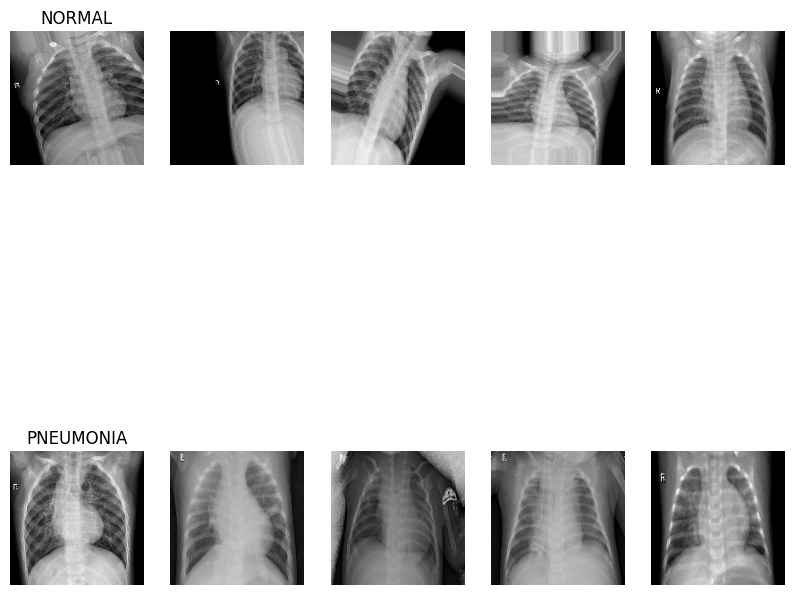

Found 12855 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 170s 400ms/step - accuracy: 0.8370 - loss: 0.4038 - val_accuracy: 0.8750 - val_loss: 0.3026
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 156s 299ms/step - accuracy: 0.9602 - loss: 0.0995 - val_accuracy: 0.9375 - val_loss: 0.2972
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 123s 300ms/step - accuracy: 0.9770 - loss: 0.0589 - val_accuracy: 0.9375 - val_loss: 0.1677
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 124s 305ms/step - accuracy: 0.9797 - loss: 0.0534 - val_accuracy: 0.8750 - val_loss: 0.3598
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 122s 297ms/step - accuracy: 0.9861 - loss: 0.0371 - val_accuracy: 0.9375 - val_loss: 0.1895
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 126s 309ms/step - accuracy: 0.9902 - loss: 0.0265 - val_accuracy: 0.9375 - val_loss: 0.2960
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 139s 301ms/step - accuracy: 0.9940 - loss: 0.0178 - val_accuracy: 0.8750 - val_loss: 0.3296
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 142s 301ms/step - accuracy: 0.9968 - loss: 0.01

In [20]:
# 4. 이변량 분석(Bivariate Analysis)
# 클래스별 샘플 이미지를 시각화
import random
from tensorflow.keras.preprocessing import image

def plot_sample_images(path, num_images=5):
    classes = os.listdir(path)  # 클래스 목록 가져오기
    fig, axes = plt.subplots(len(classes), num_images, figsize=(10, 10))  # 서브플롯 생성
    for i, cls in enumerate(classes):
        cls_path = os.path.join(path, cls)  # 각 클래스 경로
        images = random.sample(os.listdir(cls_path), num_images)  # 샘플 이미지 선택
        for j, img_file in enumerate(images):
            img = image.load_img(os.path.join(cls_path, img_file), target_size=(150, 150))  # 이미지 로드
            axes[i, j].imshow(img)  # 이미지 출력
            axes[i, j].axis('off')  # 축 비활성화
            if j == 0:
                axes[i, j].set_title(cls)  # 클래스 이름 추가
    plt.show()

# 클래스별 샘플 이미지 출력
plot_sample_images(train_path)

# 5. 타겟 예측 모델 개발(Target Prediction: Model Development)
# 학습, 검증, 테스트 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(rescale=1./255)  # 픽셀 값을 0~1 범위로 스케일링
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 생성기 설정
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(150, 150), batch_size=32, class_mode='binary')  # 학습 데이터 생성기
val_generator = val_datagen.flow_from_directory(
    val_path, target_size=(150, 150), batch_size=32, class_mode='binary')  # 검증 데이터 생성기
test_generator = test_datagen.flow_from_directory(
    test_path, target_size=(150, 150), batch_size=32, class_mode='binary')  # 테스트 데이터 생성기

# 간단한 CNN 모델 구축
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # 첫 번째 합성곱 층
    MaxPooling2D(2, 2),  # 최대 풀링
    Conv2D(64, (3, 3), activation='relu'),  # 두 번째 합성곱 층
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # 세 번째 합성곱 층
    MaxPooling2D(2, 2),
    Flatten(),  # 1D로 펼침
    Dense(512, activation='relu'),  # 완전 연결 층
    Dropout(0.5),  # 드롭아웃
    Dense(1, activation='sigmoid')  # 출력층 (이진 분류)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# 6. 모델 평가 및 결론 도출
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# 예측 및 평가 지표 생성
y_pred = (model.predict(test_generator) > 0.5).astype("int32")  # 예측 값 이진화
y_true = test_generator.classes  # 실제 클래스 레이블
print(classification_report(y_true, y_pred))  # 분류 리포트 출력
print(confusion_matrix(y_true, y_pred))  # 혼동 행렬 출력